Blok 1: Finch (Peak: 6964.0 Hz)


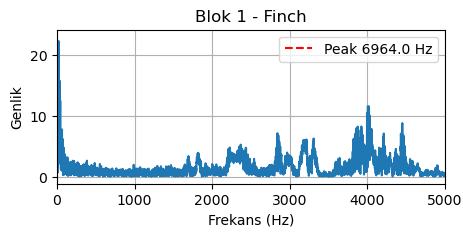

Blok 2: Finch (Peak: 4089.0 Hz)


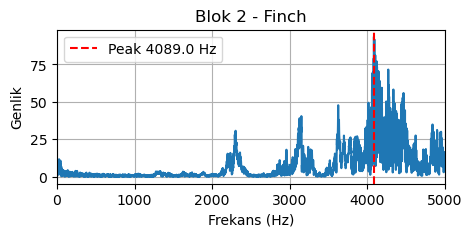

Blok 3: Finch (Peak: 4290.0 Hz)


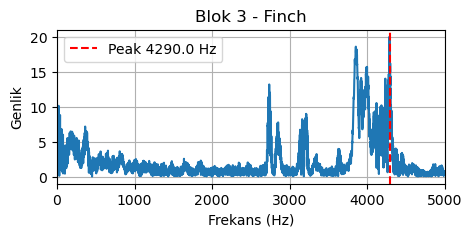

Blok 4: Kakapo (Peak: 303.0 Hz)


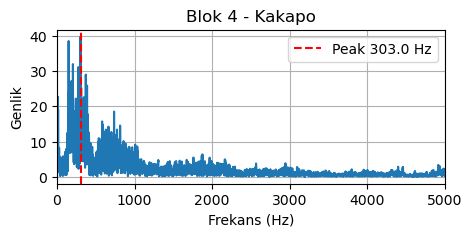

Blok 5: Kakapo (Peak: 233.0 Hz)


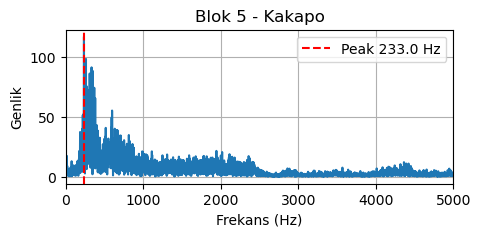

Blok 6: Kakapo (Peak: 238.0 Hz)


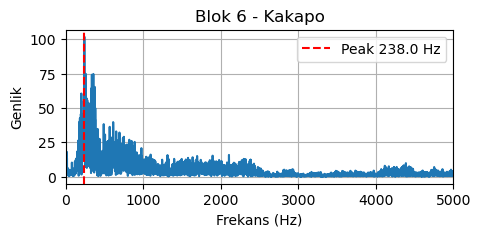

Blok 7: Kakapo (Peak: 355.0 Hz)


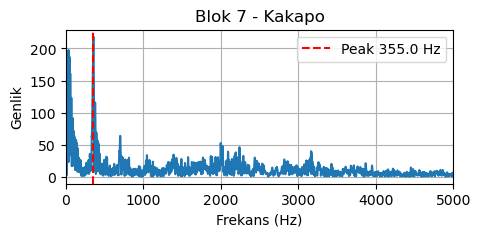

Blok 8: Finch (Peak: 6679.0 Hz)


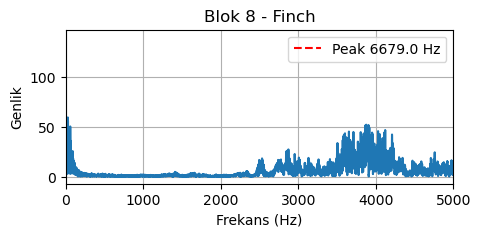

Blok 9: Finch (Peak: 3861.0 Hz)


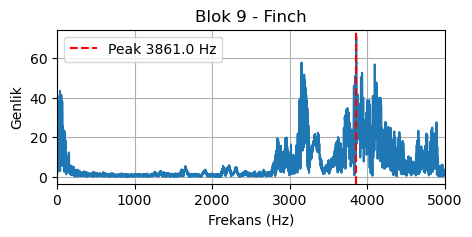

Blok 10: Finch (Peak: 3159.0 Hz)


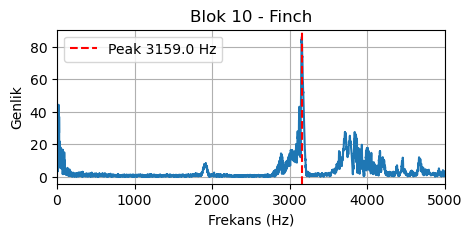

Blok 11: Finch (Peak: 4431.0 Hz)


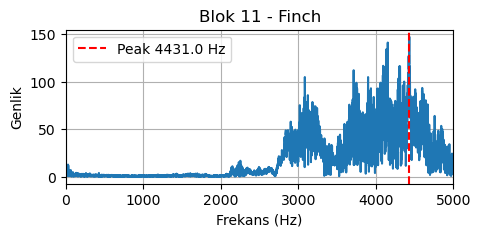

Blok 12: Kakapo (Peak: 283.0 Hz)


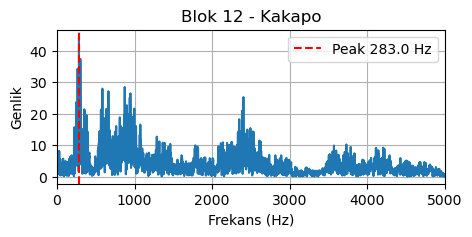

Blok 13: Kakapo (Peak: 282.0 Hz)


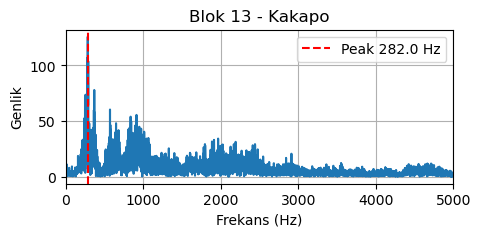

Blok 14: Kakapo (Peak: 279.0 Hz)


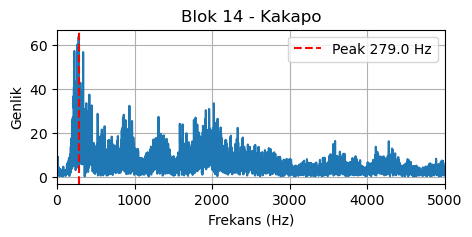

Blok 15: Sessizlik/Belirsiz (Peak: 163.0 Hz)


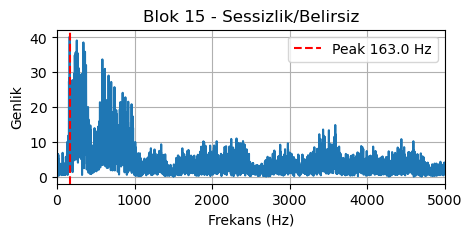

Blok 16: Kakapo (Peak: 256.0 Hz)


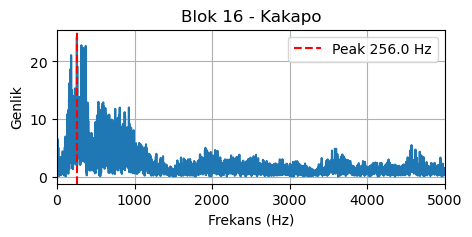

In [1]:
import librosa
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

def analyze_and_play_live_freshplot(audio_path, block_duration=1):
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    block_size = int(block_duration * sr)
    num_blocks = len(y) // block_size

    for i in range(num_blocks):
        block = y[i * block_size : (i + 1) * block_size]

        # FFT hesapla
        Y = np.fft.fft(block)
        freqs = np.fft.fftfreq(len(Y), 1/sr)
        magnitude = np.abs(Y[:len(Y)//2])
        freqs = freqs[:len(Y)//2]

        # Pik frekansı bul
        peak_index = np.argmax(magnitude)
        peak_freq = freqs[peak_index]
        if peak_freq < 200:
            species = "Sessizlik/Belirsiz"
        elif peak_freq < 1000:
            species = "Kakapo"
        else:
            species = "Finch"


        print(f"Blok {i+1}: {species} (Peak: {peak_freq:.1f} Hz)")

        # Ses çal
        sd.play(block, sr)

        # Grafik çiz
        plt.figure(figsize=(5, 2))
        plt.plot(freqs, magnitude)
        plt.axvline(x=peak_freq, color='r', linestyle='--', label=f'Peak {peak_freq:.1f} Hz')
        plt.xlim(0, 5000)
        plt.xlabel('Frekans (Hz)')
        plt.ylabel('Genlik')
        plt.title(f'Blok {i+1} - {species}')
        plt.legend()
        plt.grid()
        plt.show(block=False)
        plt.pause(block_duration)
        plt.close()

        sd.stop()

# Kullanım
analyze_and_play_live_freshplot("karisik2.mp3")


Kakapo ve Finch Ses Analizi Başlıyor...
----------------------------------------
Ses dosyası yüklendi: karisik2.mp3
Örnekleme frekansı: 44100 Hz
Ses uzunluğu: 16.30 saniye
STFT boyutları: (1025, 1405)
Frekans aralığı: 0 - 22050.0 Hz
Zaman aralığı: 0 - 16.30 saniye

STFT ile ses ayrıştırma işlemi başlıyor...
Kakapo frekans indeksleri (100-600 Hz): 23 bin
Finch frekans indeksleri (2000-6000 Hz): 186 bin
Kakapo ses gücü (RMS): 0.012728
Finch ses gücü (RMS): 0.024498
Ses ayrıştırma tamamlandı!
Kakapo eşik değeri: 0.113
Finch eşik değeri: 0.044


/var/folders/30/5wsr8cys05n_xnt6gp4tm3lh0000gn/T/ipykernel_2431/1999923823.py:213: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


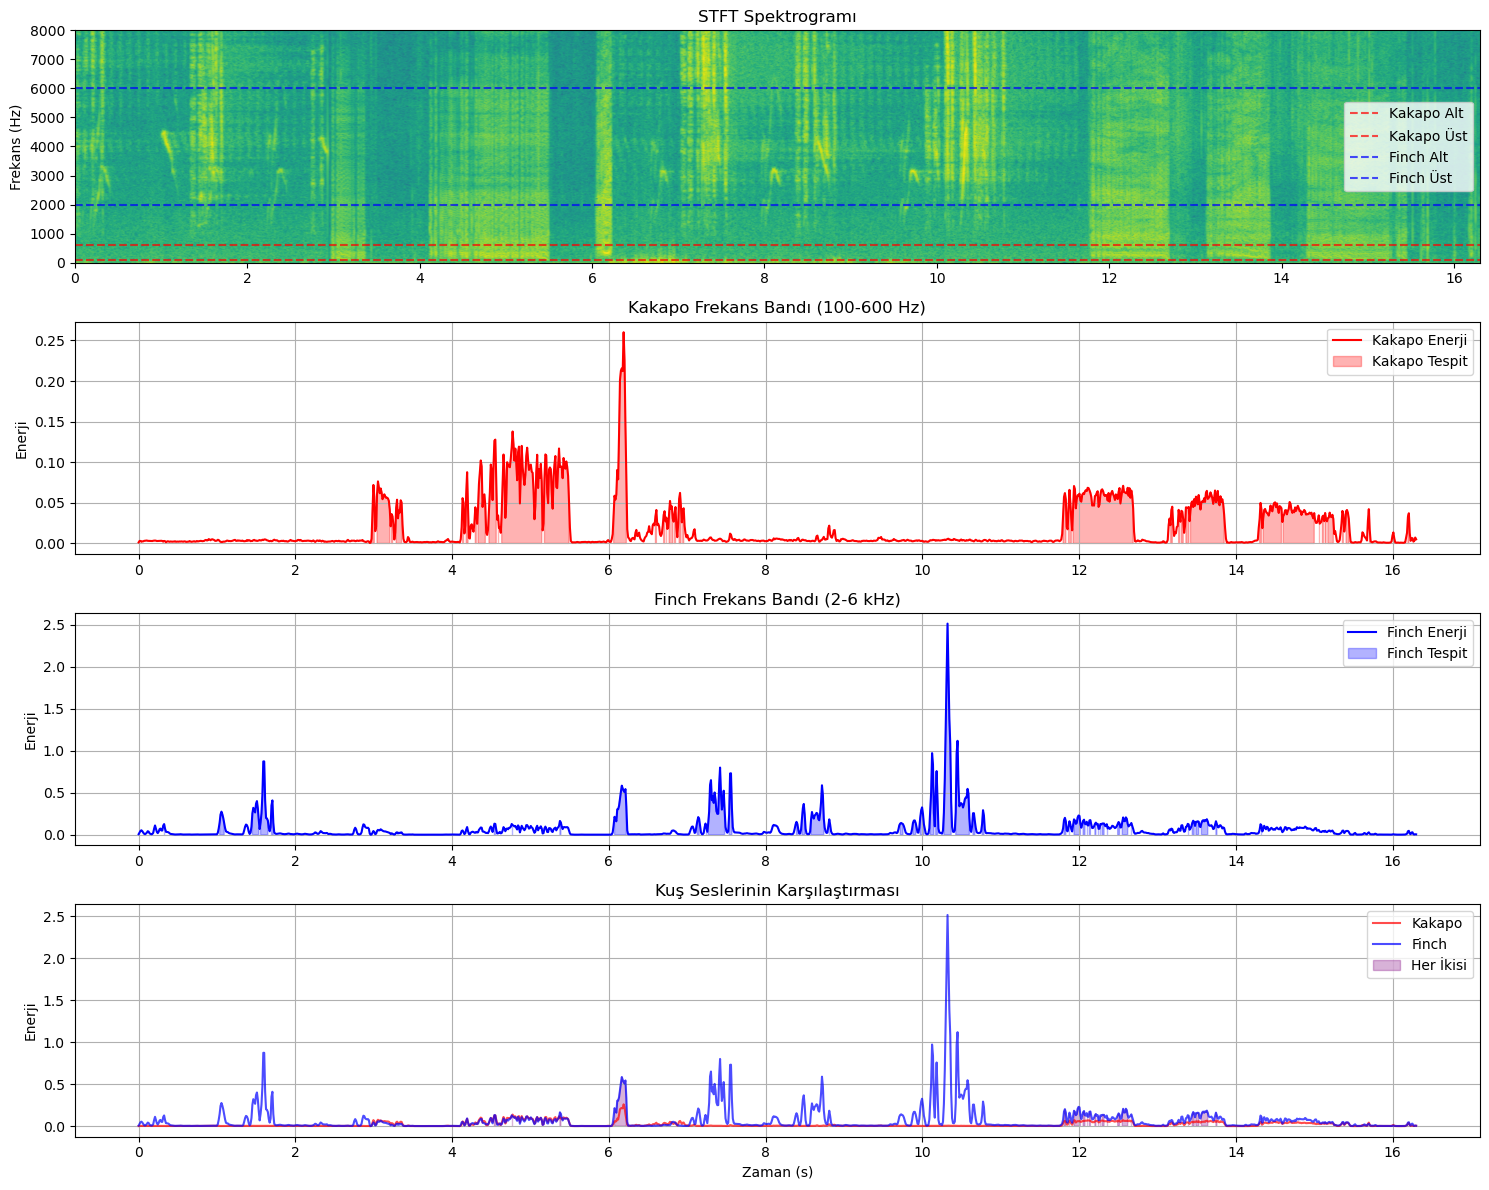


KUŞ SESİ ANALİZ RAPORU
Toplam analiz süresi: 16.30 saniye
Kakapo sesi tespit edilen süre: 3.34 saniye (20.5%)
Finch sesi tespit edilen süre: 1.49 saniye (9.1%)
Her iki ses birlikte: 0.87 saniye (5.3%)
Sessizlik/diğer: 10.60 saniye

BASKIN TÜR: KAKAPO (düşük frekanslı sesler baskın)

----------------------------------------------------------------------
SANİYE BAZINDA DETAYLI ANALİZ
----------------------------------------------------------------------
Saniye Baskın Tür         Kakapo %   Finch %    Durum
----------------------------------------------------------------------
0      Sessizlik              0.0%       1.1%   ⚫ Sessiz
1      Finch                  0.0%      30.2%   🟢 Net
2      Sessizlik              2.3%       0.0%   ⚫ Sessiz
3      Kakapo                29.1%       0.0%   🟢 Net
4      Kakapo                67.4%       3.5%   🟢 Net
5      Kakapo                47.7%       2.3%   🟢 Net
6      Kakapo                37.2%      16.3%   🟢 Net
7      Finch                  0.0%

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import signal
try:
    import sounddevice as sd
    SOUNDDEVICE_AVAILABLE = True
except ImportError:
    SOUNDDEVICE_AVAILABLE = False


from scipy.io import wavfile
import time
import os

class BirdSoundSTFTAnalyzer:
    def __init__(self):
        # Kakapo ve Finch için frekans aralıkları
        self.kakapo_freq_range = (100, 600)    # Hz - Kakapo düşük frekans aralığı
        self.finch_freq_range = (2000, 6000)   # Hz - Finch yüksek frekans aralığı
        
        # Debug için
        self.debug_mode = True
        
    def load_audio(self, file_path):
        """Ses dosyasını yükle"""
        try:
            audio, sr = librosa.load(file_path, sr=None, mono=True)
            print(f"Ses dosyası yüklendi: {file_path}")
            print(f"Örnekleme frekansı: {sr} Hz")
            print(f"Ses uzunluğu: {len(audio)/sr:.2f} saniye")
            return audio, sr
        except Exception as e:
            print(f"Ses dosyası yüklenirken hata: {e}")
            return None, None
    
    def compute_stft(self, audio, sr, window_size=2048, hop_length=512):
        """STFT hesapla"""
        # STFT hesapla
        frequencies, times, stft_matrix = signal.stft(
            audio, 
            fs=sr, 
            window='hann', 
            nperseg=window_size, 
            noverlap=window_size-hop_length
        )
        
        # Magnitude ve phase bilgilerini sakla
        magnitude = np.abs(stft_matrix)
        phase = np.angle(stft_matrix)
        
        print(f"STFT boyutları: {magnitude.shape}")
        print(f"Frekans aralığı: 0 - {frequencies[-1]:.1f} Hz")
        print(f"Zaman aralığı: 0 - {times[-1]:.2f} saniye")
        
        return frequencies, times, stft_matrix, magnitude, phase
    
    def separate_sounds_with_stft(self, frequencies, stft_matrix, sr):
        """STFT kullanarak sesleri frekans bantlarına göre ayır"""
        # Kakapo ve Finch için ayrı STFT matrisleri oluştur
        kakapo_stft = np.zeros_like(stft_matrix, dtype=complex)
        finch_stft = np.zeros_like(stft_matrix, dtype=complex)
        
        # Frekans indekslerini bul
        kakapo_indices = np.where(
            (frequencies >= self.kakapo_freq_range[0]) & 
            (frequencies <= self.kakapo_freq_range[1])
        )[0]
        
        finch_indices = np.where(
            (frequencies >= self.finch_freq_range[0]) & 
            (frequencies <= self.finch_freq_range[1])
        )[0]
        
        print(f"Kakapo frekans indeksleri ({self.kakapo_freq_range[0]}-{self.kakapo_freq_range[1]} Hz): {len(kakapo_indices)} bin")
        print(f"Finch frekans indeksleri ({self.finch_freq_range[0]}-{self.finch_freq_range[1]} Hz): {len(finch_indices)} bin")
        
        # İlgili frekans bileşenlerini kopyala
        if len(kakapo_indices) > 0:
            kakapo_stft[kakapo_indices, :] = stft_matrix[kakapo_indices, :]
        
        if len(finch_indices) > 0:
            finch_stft[finch_indices, :] = stft_matrix[finch_indices, :]
        
        # ISTFT ile zaman domenine geri dönüştür
        _, kakapo_audio = signal.istft(kakapo_stft, fs=sr, window='hann', nperseg=2048, noverlap=1536)
        _, finch_audio = signal.istft(finch_stft, fs=sr, window='hann', nperseg=2048, noverlap=1536)
        
        # Seslerin gücünü kontrol et
        kakapo_power = np.sqrt(np.mean(kakapo_audio**2))
        finch_power = np.sqrt(np.mean(finch_audio**2))
        print(f"Kakapo ses gücü (RMS): {kakapo_power:.6f}")
        print(f"Finch ses gücü (RMS): {finch_power:.6f}")
        
        return kakapo_audio, finch_audio
    
    def get_frequency_band_energy(self, frequencies, magnitude, freq_range):
        """Belirli frekans bandındaki enerjiyi hesapla"""
        # Frekans aralığına karşılık gelen indeksleri bul
        freq_indices = np.where(
            (frequencies >= freq_range[0]) & 
            (frequencies <= freq_range[1])
        )[0]
        
        if len(freq_indices) == 0:
            return np.zeros(magnitude.shape[1])
        
        # Bu frekans aralığındaki enerjileri topla
        band_energy = np.sum(magnitude[freq_indices, :], axis=0)
        return band_energy
    
    def detect_bird_presence(self, frequencies, times, magnitude, energy_threshold=0.1):
        """Kuş seslerinin varlığını tespit et"""
        # Kakapo ve Finch frekans bantlarındaki enerjileri hesapla
        kakapo_energy = self.get_frequency_band_energy(
            frequencies, magnitude, self.kakapo_freq_range
        )
        finch_energy = self.get_frequency_band_energy(
            frequencies, magnitude, self.finch_freq_range
        )
        
        # Enerjileri normalize et - HER BANT İÇİN AYRI AYRI
        # Toplam enerji yerine, her bandın kendi içinde normalize et
        kakapo_energy_normalized = kakapo_energy / (np.max(kakapo_energy) + 1e-10)
        finch_energy_normalized = finch_energy / (np.max(finch_energy) + 1e-10)
        
        # Dinamik eşik değeri - her bandın ortalamasına göre
        kakapo_threshold = np.mean(kakapo_energy_normalized) * 1.5
        finch_threshold = np.mean(finch_energy_normalized) * 1.5
        
        # Eşik değerini aşan bölgeleri tespit et
        kakapo_detection = kakapo_energy_normalized > max(energy_threshold, kakapo_threshold)
        finch_detection = finch_energy_normalized > max(energy_threshold, finch_threshold)
        
        print(f"Kakapo eşik değeri: {kakapo_threshold:.3f}")
        print(f"Finch eşik değeri: {finch_threshold:.3f}")
        
        return kakapo_energy, finch_energy, kakapo_detection, finch_detection, times
    
    def analyze_time_segments(self, times, kakapo_detection, finch_detection):
        """Zaman segmentlerini analiz et"""
        results = {
            'kakapo_segments': [],
            'finch_segments': [],
            'mixed_segments': [],
            'silence_segments': []
        }
        
        for i, time in enumerate(times):
            kakapo_present = kakapo_detection[i]
            finch_present = finch_detection[i]
            
            if kakapo_present and finch_present:
                results['mixed_segments'].append(time)
            elif kakapo_present:
                results['kakapo_segments'].append(time)
            elif finch_present:
                results['finch_segments'].append(time)
            else:
                results['silence_segments'].append(time)
        
        return results
    
    def plot_analysis(self, frequencies, times, magnitude, kakapo_energy, finch_energy, 
                     kakapo_detection, finch_detection):
        """Analiz sonuçlarını görselleştir"""
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        
        # 1. Spektrogram
        axes[0].pcolormesh(times, frequencies, 20*np.log10(magnitude + 1e-10), 
                          shading='gouraud', cmap='viridis')
        axes[0].set_ylabel('Frekans (Hz)')
        axes[0].set_title('STFT Spektrogramı')
        axes[0].set_ylim([0, 8000])  # 8 kHz'e kadar göster
        
        # Frekans aralıklarını işaretle
        axes[0].axhline(y=self.kakapo_freq_range[0], color='red', linestyle='--', alpha=0.7, label='Kakapo Alt')
        axes[0].axhline(y=self.kakapo_freq_range[1], color='red', linestyle='--', alpha=0.7, label='Kakapo Üst')
        axes[0].axhline(y=self.finch_freq_range[0], color='blue', linestyle='--', alpha=0.7, label='Finch Alt')
        axes[0].axhline(y=self.finch_freq_range[1], color='blue', linestyle='--', alpha=0.7, label='Finch Üst')
        axes[0].legend()
        
        # 2. Kakapo enerji analizi
        axes[1].plot(times, kakapo_energy, 'r-', label='Kakapo Enerji')
        axes[1].fill_between(times, 0, kakapo_energy, where=kakapo_detection, 
                           alpha=0.3, color='red', label='Kakapo Tespit')
        axes[1].set_ylabel('Enerji')
        axes[1].set_title('Kakapo Frekans Bandı (100-600 Hz)')
        axes[1].legend()
        axes[1].grid(True)
        
        # 3. Finch enerji analizi
        axes[2].plot(times, finch_energy, 'b-', label='Finch Enerji')
        axes[2].fill_between(times, 0, finch_energy, where=finch_detection, 
                           alpha=0.3, color='blue', label='Finch Tespit')
        axes[2].set_ylabel('Enerji')
        axes[2].set_title('Finch Frekans Bandı (2-6 kHz)')
        axes[2].legend()
        axes[2].grid(True)
        
        # 4. Karşılaştırma
        axes[3].plot(times, kakapo_energy, 'r-', label='Kakapo', alpha=0.7)
        axes[3].plot(times, finch_energy, 'b-', label='Finch', alpha=0.7)
        axes[3].fill_between(times, 0, np.max([kakapo_energy, finch_energy], axis=0), 
                           where=kakapo_detection & finch_detection, 
                           alpha=0.3, color='purple', label='Her İkisi')
        axes[3].set_xlabel('Zaman (s)')
        axes[3].set_ylabel('Enerji')
        axes[3].set_title('Kuş Seslerinin Karşılaştırması')
        axes[3].legend()
        axes[3].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def generate_second_by_second_analysis(self, times, kakapo_detection, finch_detection):
        """Saniye bazında detaylı analiz"""
        if len(times) == 0:
            return []
        
        total_duration = times[-1]
        second_results = []
        
        # Her saniye için analiz
        for second in range(int(total_duration) + 1):
            start_time = second
            end_time = second + 1
            
            # Bu saniyeye karşılık gelen zaman indekslerini bul
            time_indices = np.where((times >= start_time) & (times < end_time))[0]
            
            if len(time_indices) == 0:
                second_results.append({
                    'second': second,
                    'dominant': 'Sessizlik',
                    'kakapo_ratio': 0,
                    'finch_ratio': 0,
                    'both_present': False
                })
                continue
            
            # Bu saniyedeki tespit oranlarını hesapla
            kakapo_count = np.sum(kakapo_detection[time_indices])
            finch_count = np.sum(finch_detection[time_indices])
            total_frames = len(time_indices)
            
            kakapo_ratio = kakapo_count / total_frames
            finch_ratio = finch_count / total_frames
            
            # Baskın türü belirle
            both_present = kakapo_ratio > 0.3 and finch_ratio > 0.3

            
            # Baskın türü belirle
            # Baskın türü belirle
            if kakapo_ratio < 0.05 and finch_ratio < 0.05:
                dominant = 'Sessizlik'
            elif kakapo_ratio > finch_ratio:
                dominant = 'Kakapo'
            elif finch_ratio > kakapo_ratio:
                dominant = 'Finch'
            else:
                dominant = 'Karışık'

            second_results.append({
                'second': second,
                'dominant': dominant,
                'kakapo_ratio': kakapo_ratio,
                'finch_ratio': finch_ratio,
                'both_present': both_present
            })
        
        return second_results

    def save_separated_sounds(self, output_dir, kakapo_audio, finch_audio, sr):
        """Ayrıştırılmış sesleri WAV dosyası olarak kaydet"""
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        # Ses uzunluklarını eşitle
        min_len = min(len(kakapo_audio), len(finch_audio))
        kakapo_audio = kakapo_audio[:min_len]
        finch_audio = finch_audio[:min_len]
        
        # Normalize et - her birini kendi maksimumuna göre
        kakapo_max = np.max(np.abs(kakapo_audio))
        finch_max = np.max(np.abs(finch_audio))
        
        if kakapo_max > 0:
            kakapo_normalized = kakapo_audio / kakapo_max * 0.8
        else:
            kakapo_normalized = kakapo_audio
            
        if finch_max > 0:
            finch_normalized = finch_audio / finch_max * 0.8
        else:
            finch_normalized = finch_audio
        
        # WAV olarak kaydet
        kakapo_path = os.path.join(output_dir, "kakapo_separated.wav")
        finch_path = os.path.join(output_dir, "finch_separated.wav")
        both_path = os.path.join(output_dir, "both_stereo.wav")
        
        # 16-bit PCM formatına dönüştür
        kakapo_int16 = (kakapo_normalized * 32767).astype(np.int16)
        finch_int16 = (finch_normalized * 32767).astype(np.int16)
        
        # Kaydet
        wavfile.write(kakapo_path, sr, kakapo_int16)
        wavfile.write(finch_path, sr, finch_int16)
        
        # Stereo versiyonu kaydet (sol: Kakapo, sağ: Finch)
        stereo_audio = np.column_stack((kakapo_int16, finch_int16))
        wavfile.write(both_path, sr, stereo_audio)
        
        
        return kakapo_path, finch_path, both_path
    
    def generate_report(self, times, analysis_results, kakapo_detection, finch_detection):
        """Analiz raporu oluştur"""
        total_time = times[-1] if len(times) > 0 else 0
        
        kakapo_time = len(analysis_results['kakapo_segments']) * (times[1] - times[0]) if len(times) > 1 else 0
        finch_time = len(analysis_results['finch_segments']) * (times[1] - times[0]) if len(times) > 1 else 0
        mixed_time = len(analysis_results['mixed_segments']) * (times[1] - times[0]) if len(times) > 1 else 0
        
        print("\n" + "="*70)
        print("KUŞ SESİ ANALİZ RAPORU")
        print("="*70)
        print(f"Toplam analiz süresi: {total_time:.2f} saniye")
        print(f"Kakapo sesi tespit edilen süre: {kakapo_time:.2f} saniye ({kakapo_time/total_time*100:.1f}%)")
        print(f"Finch sesi tespit edilen süre: {finch_time:.2f} saniye ({finch_time/total_time*100:.1f}%)")
        print(f"Her iki ses birlikte: {mixed_time:.2f} saniye ({mixed_time/total_time*100:.1f}%)")
        print(f"Sessizlik/diğer: {(total_time-kakapo_time-finch_time-mixed_time):.2f} saniye")
        
        # Baskın tür tespiti
        if kakapo_time > finch_time:
            print(f"\nBASKIN TÜR: KAKAPO (düşük frekanslı sesler baskın)")
        elif finch_time > kakapo_time:
            print(f"\nBASKIN TÜR: FINCH (yüksek frekanslı sesler baskın)")
        else:
            print(f"\nHER İKİ TÜR EŞİT ORANDA TESPİT EDİLDİ")
        
        # Saniye bazında analiz
        second_analysis = self.generate_second_by_second_analysis(times, kakapo_detection, finch_detection)
        
        print("\n" + "-"*70)
        print("SANİYE BAZINDA DETAYLI ANALİZ")
        print("-"*70)
        print(f"{'Saniye':<6} {'Baskın Tür':<18} {'Kakapo %':<10} {'Finch %':<10} {'Durum'}")
        print("-"*70)
        
        for result in second_analysis:
            status = "🟢 Net" if result['dominant'] in ['Kakapo', 'Finch'] else \
                    "🟡 Karışık" if result['both_present'] else "⚫ Sessiz"
            
            print(f"{result['second']:<6} {result['dominant']:<18} "
                  f"{result['kakapo_ratio']*100:>7.1f}%   "
                  f"{result['finch_ratio']*100:>7.1f}%   {status}")
        
        return second_analysis
        """Analiz raporu oluştur"""
        total_time = times[-1] if len(times) > 0 else 0
        
        kakapo_time = len(analysis_results['kakapo_segments']) * (times[1] - times[0]) if len(times) > 1 else 0
        finch_time = len(analysis_results['finch_segments']) * (times[1] - times[0]) if len(times) > 1 else 0
        mixed_time = len(analysis_results['mixed_segments']) * (times[1] - times[0]) if len(times) > 1 else 0
        
        print("\n" + "="*70)
        print("KUŞ SESİ ANALİZ RAPORU")
        print("="*70)
        print(f"Toplam analiz süresi: {total_time:.2f} saniye")
        print(f"Kakapo sesi tespit edilen süre: {kakapo_time:.2f} saniye ({kakapo_time/total_time*100:.1f}%)")
        print(f"Finch sesi tespit edilen süre: {finch_time:.2f} saniye ({finch_time/total_time*100:.1f}%)")
        print(f"Her iki ses birlikte: {mixed_time:.2f} saniye ({mixed_time/total_time*100:.1f}%)")
        print(f"Sessizlik/diğer: {(total_time-kakapo_time-finch_time-mixed_time):.2f} saniye")
        
        # Baskın tür tespiti
        if kakapo_time > finch_time:
            print(f"\nBASKIN TÜR: KAKAPO (düşük frekanslı sesler baskın)")
        elif finch_time > kakapo_time:
            print(f"\nBASKIN TÜR: FINCH (yüksek frekanslı sesler baskın)")
        else:
            print(f"\nHER İKİ TÜR EŞİT ORANDA TESPİT EDİLDİ")
        
        # Saniye bazında analiz
        second_analysis = self.generate_second_by_second_analysis(times, kakapo_detection, finch_detection)
        
        print("\n" + "-"*70)
        print("SANİYE BAZINDA DETAYLI ANALİZ")
        print("-"*70)
        print(f"{'Saniye':<6} {'Baskın Tür':<18} {'Kakapo %':<10} {'Finch %':<10} {'Durum'}")
        print("-"*70)
        
        for result in second_analysis:
            status = "🟢 Net" if result['dominant'] in ['Kakapo', 'Finch'] else \
                    "🟡 Karışık" if result['both_present'] else "⚫ Sessiz"
            
            print(f"{result['second']:<6} {result['dominant']:<18} "
                  f"{result['kakapo_ratio']*100:>7.1f}%   "
                  f"{result['finch_ratio']*100:>7.1f}%   {status}")
        
        return second_analysis
    
    def play_separated_sounds(self, audio, sr, kakapo_audio, finch_audio, mode='both'):
        """STFT ile ayrıştırılmış sesleri çal"""
        if not SOUNDDEVICE_AVAILABLE:
            self.save_separated_sounds("./separated_sounds", kakapo_audio, finch_audio, sr)
            return
     
        
        # Ses uzunluklarını eşitle
        min_len = min(len(audio), len(kakapo_audio), len(finch_audio))
        audio = audio[:min_len]
        kakapo_audio = kakapo_audio[:min_len]
        finch_audio = finch_audio[:min_len]
        
        # Sesleri normalize et
        kakapo_audio = kakapo_audio / (np.max(np.abs(kakapo_audio)) + 1e-10)
        finch_audio = finch_audio / (np.max(np.abs(finch_audio)) + 1e-10)
        
        if mode == 'original':
            print("Orijinal ses çalınıyor...")
            sd.play(audio, sr)
            sd.wait()
            
        elif mode == 'kakapo':
            print("Sadece KAKAPO sesi çalınıyor (100-600 Hz)...")
            print("STFT ile ayrıştırılmış düşük frekans bileşenleri")
            sd.play(kakapo_audio * 0.5, sr)  # Ses seviyesini ayarla
            sd.wait()
            
        elif mode == 'finch':
            print("Sadece FINCH sesi çalınıyor (2-6 kHz)...")
            print("STFT ile ayrıştırılmış yüksek frekans bileşenleri")
            sd.play(finch_audio * 0.5, sr)  # Ses seviyesini ayarla
            sd.wait()
            
        elif mode == 'both':
            print("Her iki kuş sesi AYNI ANDA çalınıyor...")
            print("Sol Kanal: Kakapo (100-600 Hz)")
            print("Sağ Kanal: Finch (2-6 kHz)")
            # Sol kanal Kakapo, sağ kanal Finch olacak şekilde stereo ses oluştur
            stereo_audio = np.column_stack((kakapo_audio * 0.7, finch_audio * 0.7))
            sd.play(stereo_audio, sr)
            sd.wait()
            
        elif mode == 'sequential':
            print("Sırayla çalınıyor...")
            print("\n-> Kakapo sesi (100-600 Hz) çalıyor...")
            sd.play(kakapo_audio * 0.5, sr)
            sd.wait()
            time.sleep(1)
            print("\n-> Finch sesi (2-6 kHz) çalıyor...")
            sd.play(finch_audio * 0.5, sr)
            sd.wait()
            
        elif mode == 'mixed':
          
            mixed_audio = (kakapo_audio + finch_audio) * 0.5
            sd.play(mixed_audio, sr)
            sd.wait()
    
    def analyze_audio_file(self, file_path, energy_threshold=0.1, plot_results=True, play_mode=None, save_audio=True):
        """Ana analiz fonksiyonu"""
        # Ses dosyasını yükle
        audio, sr = self.load_audio(file_path)
        if audio is None:
            return None
        
        # STFT hesapla
        frequencies, times, stft_matrix, magnitude, phase = self.compute_stft(audio, sr)
        
        # STFT kullanarak sesleri ayır
        print("\nSTFT ile ses ayrıştırma işlemi başlıyor...")
        kakapo_audio, finch_audio = self.separate_sounds_with_stft(frequencies, stft_matrix, sr)
        print("Ses ayrıştırma tamamlandı!")
        
        # Sesleri kaydet
        if save_audio:
            self.save_separated_sounds("./separated_sounds", kakapo_audio, finch_audio, sr)
        
        # Kuş seslerini tespit et
        kakapo_energy, finch_energy, kakapo_detection, finch_detection, times = self.detect_bird_presence(
            frequencies, times, magnitude, energy_threshold
        )
        
        # Zaman segmentlerini analiz et
        analysis_results = self.analyze_time_segments(times, kakapo_detection, finch_detection)
        
        # Sonuçları görselleştir
        if plot_results:
            self.plot_analysis(frequencies, times, magnitude, kakapo_energy, finch_energy, 
                             kakapo_detection, finch_detection)
        
        # Rapor oluştur
        second_by_second = self.generate_report(times, analysis_results, kakapo_detection, finch_detection)
        
        # Sesleri çal
        if play_mode and SOUNDDEVICE_AVAILABLE:
            self.play_separated_sounds(audio, sr, kakapo_audio, finch_audio, play_mode)
        
        return {
            'frequencies': frequencies,
            'times': times,
            'magnitude': magnitude,
            'kakapo_energy': kakapo_energy,
            'finch_energy': finch_energy,
            'kakapo_detection': kakapo_detection,
            'finch_detection': finch_detection,
            'analysis_results': analysis_results,
            'second_by_second': second_by_second,
            'kakapo_audio': kakapo_audio,
            'finch_audio': finch_audio,
            'original_audio': audio,
            'sample_rate': sr
        }


if __name__ == "__main__":

    analyzer = BirdSoundSTFTAnalyzer()
    
  
    file_path = "karisik2.mp3" 
    print("Kakapo ve Finch Ses Analizi Başlıyor...")
    print("-" * 40)
    
 

    results = analyzer.analyze_audio_file(
        file_path, 
        energy_threshold=0.05,
        plot_results=True,
        play_mode='both'  # Her iki kuş sesini aynı anda çal
    )
    
    if results:
        print("\nAnaliz tamamlandı!")
      
        
  
    else:
        print("Analiz başarısız!")